In [1]:
!git clone https://github.com/thibo73800/capsnet_traffic_sign_classifier.git
!cd capsnet_traffic_sign_classifier.git
!wget https://d17h27t6h515a5.cloudfront.net/topher/2017/February/5898cd6f_traffic-signs-data/traffic-signs-data.zip
!unzip traffic-signs-data.zip
!mkdir dataset
!mv *.p dataset/
!rm traffic-signs-data.zip

Cloning into 'capsnet_traffic_sign_classifier'...
remote: Enumerating objects: 110, done.
remote: Total 110 (delta 0), reused 0 (delta 0), pack-reused 110
Receiving objects: 100% (110/110), 1.34 MiB | 8.40 MiB/s, done.
Resolving deltas: 100% (51/51), done.
/bin/bash: line 1: cd: capsnet_traffic_sign_classifier.git: No such file or directory
--2024-05-14 01:37:47--  https://d17h27t6h515a5.cloudfront.net/topher/2017/February/5898cd6f_traffic-signs-data/traffic-signs-data.zip
Resolving d17h27t6h515a5.cloudfront.net (d17h27t6h515a5.cloudfront.net)... 18.172.139.98, 18.172.139.41, 18.172.139.86, ...
Connecting to d17h27t6h515a5.cloudfront.net (d17h27t6h515a5.cloudfront.net)|18.172.139.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 123524425 (118M) [application/zip]
Saving to: ‘traffic-signs-data.zip’

traffic-signs-data. 100%[===================>] 117.80M   175MB/s    in 0.7s    

2024-05-14 01:37:48 (175 MB/s) - ‘traffic-signs-data.zip’ saved [123524425/123524

In [2]:
import numpy as np  # Added to use numpy functions

training_file = "dataset/train.p"
validation_file= "dataset/valid.p"
testing_file = "dataset/test.p"

with open(training_file, mode='rb') as f:
    train = np.load(f, allow_pickle=True)
with open(validation_file, mode='rb') as f:
    valid = np.load(f, allow_pickle=True)
with open(testing_file, mode='rb') as f:
    test = np.load(f, allow_pickle=True)

X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

# Print the shape of variables
print(X_train.shape)
print(y_train.shape)

n_train = len(X_train)
n_validation = len(X_valid)
n_test = len(X_test)
image_shape = X_train[0].shape

# unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)
print(n_train, n_validation, n_test)

(34799, 32, 32, 3)
(34799,)
Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43
34799 4410 12630


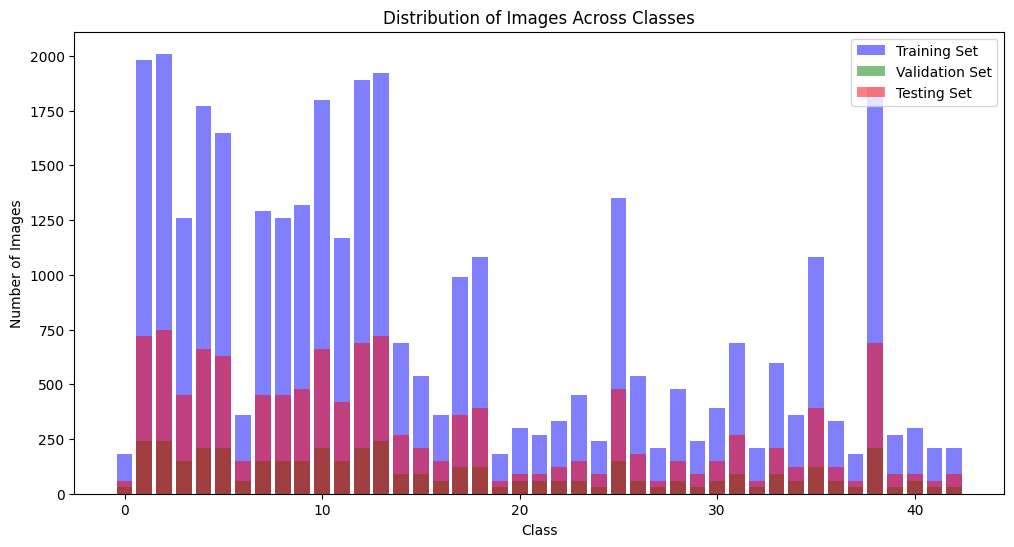

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Count the number of images per class
class_counts_train, _ = np.histogram(y_train, bins=np.arange(n_classes+1))
class_counts_valid, _ = np.histogram(y_valid, bins=np.arange(n_classes+1))
class_counts_test, _ = np.histogram(y_test, bins=np.arange(n_classes+1))

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(range(n_classes), class_counts_train, color='blue', alpha=0.5, label='Training Set')
plt.bar(range(n_classes), class_counts_valid, color='green', alpha=0.5, label='Validation Set')
plt.bar(range(n_classes), class_counts_test, color='red', alpha=0.5, label='Testing Set')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Distribution of Images Across Classes')
plt.legend(loc='upper right')
plt.show()

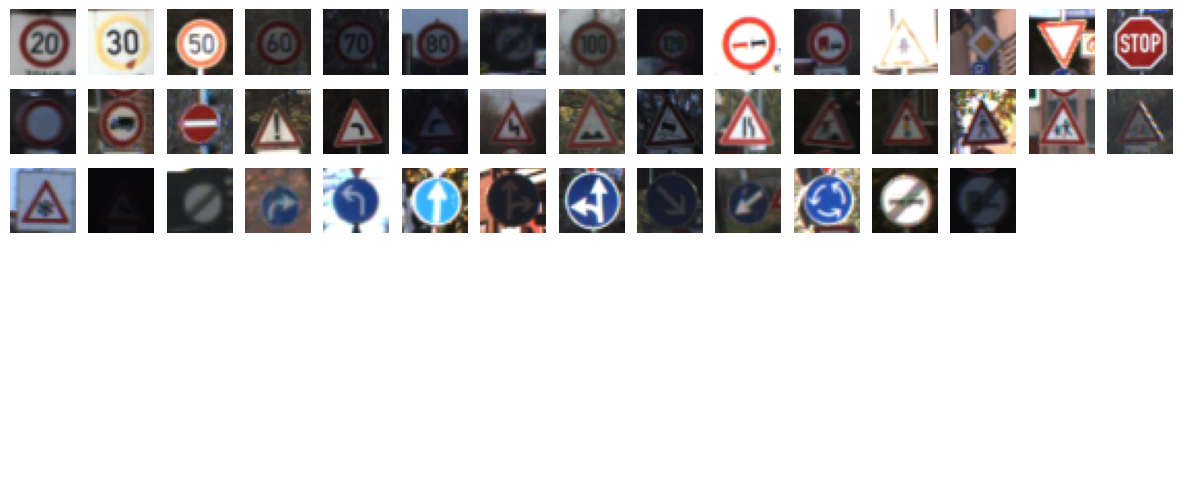

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.image as mpimg
import random

def split_by_class(y_data) :
    """
    Returns a dictionary whose keys are the class labels
    and key values are list of indices with that class label.
    """
    img_index = {}
    labels = set(y_data)
    for i, y in enumerate(y_data):
        if y not in img_index.keys():
            img_index[y] = [i]
        else:
            img_index[y].append(i)
    return img_index

def display_sample_images(X_data, y_data, i_start='random') :
    """
    Displays images from each class,
    i_start is the starting index in each class.
    By default, images are randomly chosen from each class
    """
    img_index = split_by_class(y_data)
    labels = list(set(y_data))[::-1]
    fig, axes = plt.subplots(6, 15, figsize=(15, 6))
    for ax in axes.flatten() :
        if labels : #labels!= 0
            i_img = 0
            if i_start == 'random':
                i_img = random.choice(img_index[labels.pop()])
            else :
                i_img = img_index[labels.pop()][i_start]
            ax.imshow(X_train[i_img])
        ax.axis('off')


display_sample_images(X_train, y_train)



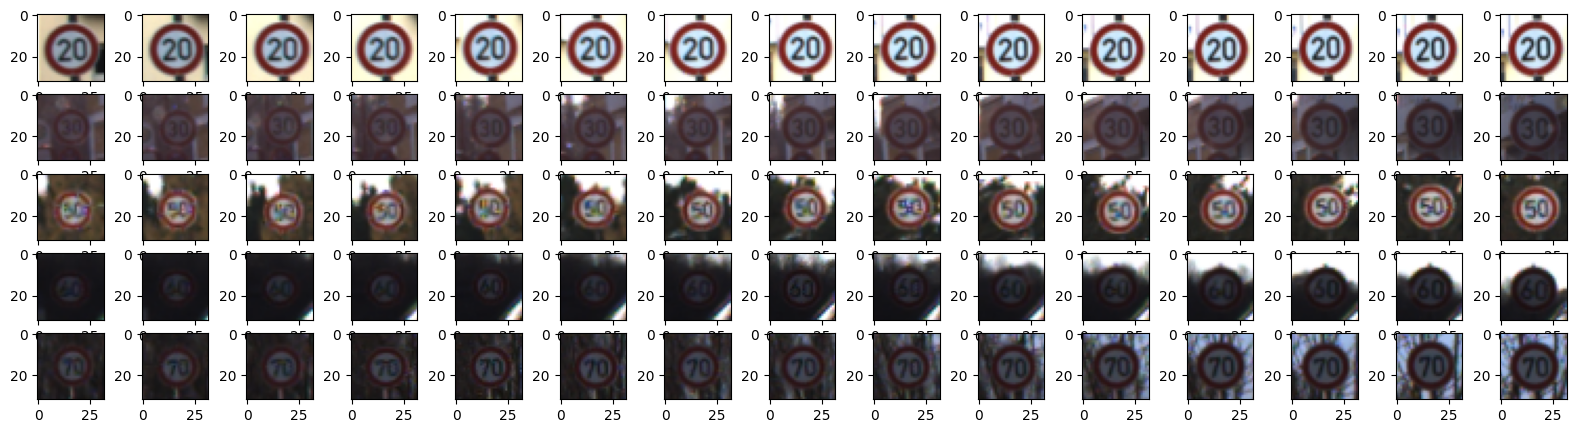

In [5]:
img_index = split_by_class(y_train)
fig, ax = plt.subplots(5, 15, figsize=(20, 5))
for label in range(5) :
    for i in range(15) :
        ax[label, i].imshow(X_train[img_index[label][i]])
        ax[label, i].axis('on')

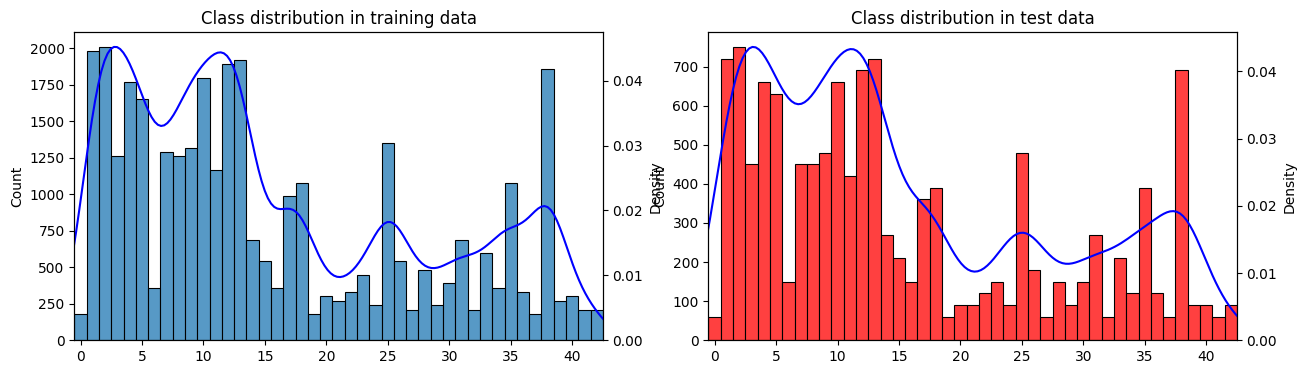

In [6]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def plot_dist(y_data, title=None, ax=None, **kwargs):
    if not ax:
        fig, ax = plt.subplots()
    sns.histplot(y_data, bins=np.arange(-0.5, n_classes+1.5), kde=False, ax=ax, **kwargs)
    sns.kdeplot(y_data, color='blue', ax=ax.twinx())
    ax.set_xlim(-0.5, n_classes-0.5)
    if 'label' in kwargs:
        ax.legend()
    if title:
        ax.set_title(title)

fig, ax = plt.subplots(1, 2, figsize=(15, 4))
plot_dist(y_train, title='Class distribution in training data', ax=ax[0])
plot_dist(y_test, title='Class distribution in test data', ax=ax[1], color='red')

plt.show()


Text(0.5, 1.0, 'Contrast Norm.')

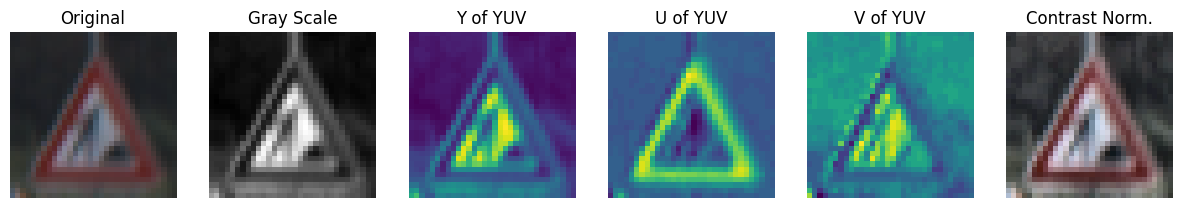

In [7]:
import cv2
import random
from sklearn.utils import shuffle

def min_max_norm(image, a=-.5, b=.5) :
    Xmin, Xmax = np.min(image), np.max(image)
    return (image-Xmin)*(b-a)/(Xmax-Xmin)

def abs_norm(image, a=-.5, b=0.5, col_min=0, col_max=255) :
    return (image-col_min)*(b-a)/(col_max-col_min)

def grayscale_norm(image) :
    # Convert to grayscale
    img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return min_max_norm(img)

def YUV_norm(image) :
    # Converted to YUV color space
    new_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    # Normalize the Y channel
    [y,u,v] = [new_image[:,:,i] for i in range(3)]
    new_image = np.zeros(image.shape)
    new_image[:,:,0] = min_max_norm(y)
    new_image[:,:,1],new_image[:,:,2] = abs_norm(u), abs_norm(v)
    return new_image

def contrast_norm(image) :
    # Convert to LAB colorspace
    lab= cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    # Applied adaptive histogram equalization
    l = lab[:,:,0]
    clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(4,4))
    cl = clahe.apply(l)
    lab[:,:,0] = cl
    # Convert back to RGB and scale values
    img =  cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    new_img = np.zeros(image.shape)
    for i in range(3) :
        new_img[:,:,i] = abs_norm(img[:,:,i])
    return new_img

img_index = split_by_class(y_train)
img = X_train[img_index[25][20]]
fig, ax = plt.subplots(1,6, figsize=(15,3))
for axes in ax :
    axes.axis('off')

# Original image
ax[0].imshow(img)
ax[0].set_title('Original')
# Grayscale normalized
ax[1].imshow(grayscale_norm(img), cmap='gray')
ax[1].set_title('Gray Scale')
# YUV normalized (Y channel)
ax[2].imshow(YUV_norm(img)[:,:,0])
ax[2].set_title('Y of YUV')
# YUV normalized (U channel)
ax[3].imshow(YUV_norm(img)[:,:,1])
ax[3].set_title('U of YUV')
# YUV normalized (V channel)
ax[4].imshow(YUV_norm(img)[:,:,2])
ax[4].set_title('V of YUV')
# Contrast normalized
ax[5].imshow(contrast_norm(img))
ax[5].set_title('Contrast Norm.')


In [8]:
from sklearn.model_selection import train_test_split

def split_train_validation(X_data, y_data) :
    # Initialize lists to store training and validation data
    X_train_new, y_train_new = [], []
    X_validation, y_validation = [], []

    n_per_track = 30  # Images per track
    img_index = split_by_class(y_data)

    for label in range(n_classes):
        indices = img_index[label]
        n_tracks = round(len(indices) / n_per_track)  # Number of tracks for this label

        # Split the data into tracks
        X_list = np.array_split(X_data[indices[0]:indices[-1] + 1], n_tracks)
        y_list = np.array_split(y_data[indices[0]:indices[-1] + 1], n_tracks)

        # Shuffled the tracks
        X_list, y_list = shuffle(X_list, y_list, random_state=0)

        # Separating the first track as validation data, rest as training data
        X_validation.append(X_list[0])
        y_validation.append(y_list[0])
        X_train_new += X_list[1:]
        y_train_new += y_list[1:]

    return (np.concatenate(X_train_new), np.concatenate(y_train_new),
            np.concatenate(X_validation), np.concatenate(y_validation))

def split_train_validation_alt(X_data, y_data):
    X_train, X_validation, y_train, y_validation = train_test_split(X_data, y_data, test_size=0.1, random_state=0, stratify=y_data)
    return X_train, y_train, X_validation, y_validation

X_train_new, y_train_new, X_validation, y_validation = split_train_validation(X_train, y_train)
print("New training data shape is : ", X_train_new.shape)
print("Validation data shape is : ", X_validation.shape)

# # Plot the distribution of classes in the new training and validation sets
# plot_dist([y_train_new, y_validation], title='Class distribution',
#           label=['Training','Validation'], color=['blue','orange'])


New training data shape is :  (33509, 32, 32, 3)
Validation data shape is :  (1290, 32, 32, 3)


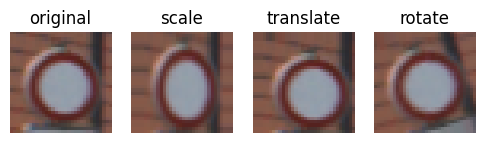

In [9]:
def scale(img, x_scale=0.85, y_scale=1.15):
    # Keeping original dimensions for consistency
    r_orig, c_orig = img.shape[:-1]
    scaled_img = cv2.resize(img, None, fx=x_scale, fy=y_scale)
    # constant padding size
    padded_img = cv2.copyMakeBorder(scaled_img, 5, 5, 5, 5, cv2.BORDER_REPLICATE)
    # Adjusted return values for padding consistency
    r_pad, c_pad = padded_img.shape[:-1]
    r_start, c_start = (r_pad - r_orig) // 2, (c_pad - c_orig) // 2
    return padded_img[r_start:r_start + r_orig, c_start:c_start + c_orig]  # Updated indexing

def translate(img, delta_x=2, delta_y=-2):
    r_orig, c_orig = img.shape[:-1]
    padded_img = cv2.copyMakeBorder(img, 5, 5, 5, 5, cv2.BORDER_REPLICATE)
    # Adjusted return values for padding consistency
    r_pad, c_pad = padded_img.shape[:-1]
    r_start, c_start = (r_pad - r_orig) // 2 + delta_y, (c_pad - c_orig) // 2 - delta_x
    return padded_img[r_start:r_start + r_orig, c_start:c_start + c_orig]  # Updated indexing

def rotate(img, theta=18):
    r_orig, c_orig = img.shape[:-1]
    padded_img = cv2.copyMakeBorder(img, 5, 5, 5, 5, cv2.BORDER_REPLICATE)
    # rotation around the center of the image
    r_pad, c_pad = padded_img.shape[:-1]  # Renamed variables for clarity
    rotation_matrix = cv2.getRotationMatrix2D((c_pad / 2, r_pad / 2), theta, 1)  # Updated center coordinates
    rotated_img = cv2.warpAffine(padded_img, rotation_matrix, (c_pad, r_pad))  # Adjusted image size
    # Adjusted return values for padding consistency
    r_start, c_start = (r_pad - r_orig) // 2, (c_pad - c_orig) // 2  # Renamed variables for clarity
    return rotated_img[r_start:r_start + r_orig, c_start:c_start + c_orig]  # Updated indexing


# check if the transformations work
img = X_train[img_index[15][200]]
def original(img) : return img
fig, ax = plt.subplots(1,4, figsize=(6,2))
for i,transform in enumerate([original, scale, translate, rotate]) :
    ax[i].imshow(transform(img))
    ax[i].axis('off')
    ax[i].set_title(transform.__name__)

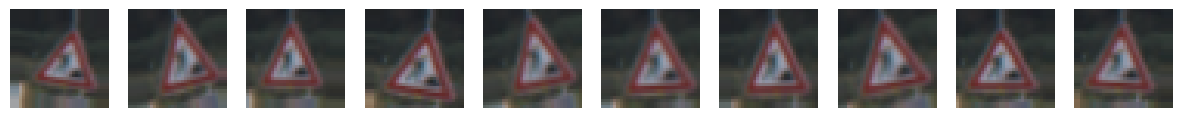

In [10]:
random_scale = lambda img : scale(img, x_scale=random.uniform(0.85, 1.1), y_scale=random.uniform(0.85, 1.1))
random_translate = lambda img : translate(img, delta_x=random.randint(-2, 2), delta_y=random.randint(-2, 2))
random_rotate = lambda img : rotate(img, theta=random.uniform(-17., 17.))

def random_transform(img):
    new_img = img.copy()
    transform_list = [random_scale, random_translate, random_rotate]
    random.shuffle(transform_list)
    for transform in transform_list:
        new_img = transform(new_img)
    return new_img

# check
img = X_train[img_index[25][10]]
fig, ax = plt.subplots(1,10, figsize=(15,2))
for i in range(10) :
    ax[i].imshow(random_transform(img))
    ax[i].axis('off')

In [11]:
from tqdm import tqdm

def perturb_data(X_data, y_data):
    """
    Splits the dataset retaining half the original images
    while perturbing the other half of the images.
    """
    X_original, y_original = [], []
    X_perturbed, y_perturbed = [], []
    num_images = len(X_data)
    with tqdm(total=num_images, unit=' images', desc='Original data perturbation') as images_pbar:
        for i, img in enumerate(X_data):
            if i % 2 == 0:
                X_original.append(img)
                y_original.append(y_data[i])
            else:
                X_perturbed.append(random_transform(img))
                y_perturbed.append(y_data[i])
            images_pbar.update(1)
    return np.array(X_original), np.array(y_original), np.array(X_perturbed), np.array(y_perturbed)

def augment_data(X_data, y_data, n=300):
    """
    Augments the dataset so that there are n images per class.
    """
    X_augmented, y_augmented = [], []
    class_indices = split_by_class(y_data)
    num_classes = len(class_indices)
    with tqdm(total=num_classes, unit=' classes', desc='Data augmentation') as class_pbar:
        for label, indices in class_indices.items():
            num_images_label = len(indices)
            print(num_images_label)  # Check for all 43 labels
            n_augmented = n - num_images_label
            if n_augmented <= 0:
                continue
            for _ in range(n_augmented):
                i_img = random.choice(indices)
                img = X_data[i_img]
                X_augmented.append(random_transform(img))
                y_augmented.append(label)
            class_pbar.update(1)
    return np.array(X_augmented), np.array(y_augmented)

from time import sleep

print('Training dataset augmentation')
sleep(1)
X_train_given, y_train_given, X_train_perturbed, y_train_perturbed = perturb_data(X_train_new, y_train_new)
X_train_augmented, y_train_augmented = augment_data(X_train_new, y_train_new, n=5000)
del X_train_new, y_train_new


Training dataset augmentation


Data augmentation:   0%|          | 0/43 [00:00<?, ? classes/s]

150


Data augmentation:   2%|▏         | 1/43 [00:00<00:17,  2.44 classes/s]

1950


Data augmentation:   5%|▍         | 2/43 [00:00<00:13,  2.99 classes/s]

1980


Data augmentation:   7%|▋         | 3/43 [00:00<00:12,  3.22 classes/s]

1230


Data augmentation:   9%|▉         | 4/43 [00:01<00:12,  3.04 classes/s]

1740


Data augmentation:  12%|█▏        | 5/43 [00:01<00:12,  3.10 classes/s]

1620


Data augmentation:  14%|█▍        | 6/43 [00:01<00:11,  3.08 classes/s]

330


Data augmentation:  16%|█▋        | 7/43 [00:02<00:13,  2.73 classes/s]

1260


Data augmentation:  21%|██        | 9/43 [00:02<00:09,  3.46 classes/s]

1230
1290


Data augmentation:  26%|██▌       | 11/43 [00:03<00:07,  4.32 classes/s]

1770
1140


Data augmentation:  30%|███       | 13/43 [00:03<00:06,  4.68 classes/s]

1860
1890


Data augmentation:  33%|███▎      | 14/43 [00:03<00:05,  4.87 classes/s]

660


Data augmentation:  35%|███▍      | 15/43 [00:04<00:05,  4.72 classes/s]

510


Data augmentation:  37%|███▋      | 16/43 [00:04<00:06,  4.45 classes/s]

330


Data augmentation:  40%|███▉      | 17/43 [00:04<00:06,  4.24 classes/s]

960


Data augmentation:  42%|████▏     | 18/43 [00:04<00:05,  4.23 classes/s]

1050


Data augmentation:  44%|████▍     | 19/43 [00:05<00:05,  4.32 classes/s]

150


Data augmentation:  47%|████▋     | 20/43 [00:05<00:05,  4.22 classes/s]

270


Data augmentation:  49%|████▉     | 21/43 [00:05<00:05,  4.08 classes/s]

240


Data augmentation:  51%|█████     | 22/43 [00:05<00:05,  3.97 classes/s]

300


Data augmentation:  53%|█████▎    | 23/43 [00:06<00:05,  3.97 classes/s]

420


Data augmentation:  56%|█████▌    | 24/43 [00:06<00:04,  4.01 classes/s]

210


Data augmentation:  58%|█████▊    | 25/43 [00:06<00:04,  3.98 classes/s]

1320


Data augmentation:  60%|██████    | 26/43 [00:06<00:04,  4.19 classes/s]

510


Data augmentation:  63%|██████▎   | 27/43 [00:07<00:03,  4.18 classes/s]

180


Data augmentation:  65%|██████▌   | 28/43 [00:07<00:03,  4.10 classes/s]

450


Data augmentation:  67%|██████▋   | 29/43 [00:07<00:03,  4.13 classes/s]

210


Data augmentation:  70%|██████▉   | 30/43 [00:07<00:03,  4.01 classes/s]

360


Data augmentation:  72%|███████▏  | 31/43 [00:08<00:03,  3.98 classes/s]

660


Data augmentation:  74%|███████▍  | 32/43 [00:08<00:02,  4.09 classes/s]

180


Data augmentation:  77%|███████▋  | 33/43 [00:08<00:02,  4.01 classes/s]

569


Data augmentation:  79%|███████▉  | 34/43 [00:08<00:02,  3.98 classes/s]

330


Data augmentation:  81%|████████▏ | 35/43 [00:09<00:01,  4.04 classes/s]

1050


Data augmentation:  84%|████████▎ | 36/43 [00:09<00:01,  4.24 classes/s]

300


Data augmentation:  86%|████████▌ | 37/43 [00:09<00:01,  4.17 classes/s]

150


Data augmentation:  91%|█████████ | 39/43 [00:09<00:00,  4.38 classes/s]

1830
240


Data augmentation:  93%|█████████▎| 40/43 [00:10<00:00,  4.21 classes/s]

270


Data augmentation:  95%|█████████▌| 41/43 [00:10<00:00,  4.08 classes/s]

180


Data augmentation:  98%|█████████▊| 42/43 [00:10<00:00,  3.99 classes/s]

180


Data augmentation: 100%|██████████| 43/43 [00:10<00:00,  3.92 classes/s]


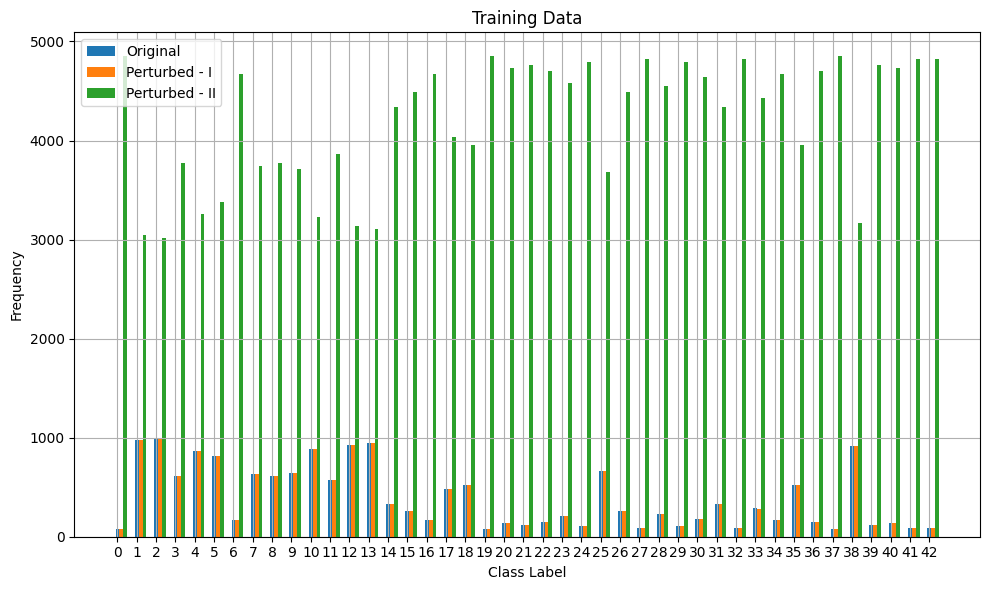

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def plot_dist(datasets, title='Class Distribution', label=None):
    """
    Plot the distribution of classes in multiple datasets.

    Parameters:
        datasets (list of arrays): List containing arrays of class labels for each dataset.
        title (str): Title of the plot.
        label (list of str): List of labels for each dataset (optional).
    """
    # Calculate the number of unique classes
    num_classes = np.max(np.concatenate(datasets)) + 1

    # Count occurrences of each class in each dataset
    class_counts = [np.bincount(dataset, minlength=num_classes) for dataset in datasets]

    # Plotting
    plt.figure(figsize=(10, 6))
    for i, counts in enumerate(class_counts):
        plt.bar(np.arange(num_classes) + i * 0.2, counts, width=0.2, align='center', label=label[i] if label else f'Dataset {i+1}')

    # Add labels and title
    plt.xlabel('Class Label')
    plt.ylabel('Frequency')
    plt.title(title)

    # Add class labels on X-axis
    plt.xticks(np.arange(num_classes), [str(i) for i in range(num_classes)])

    # Add legend
    if label:
        plt.legend()

    # Add grid lines
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_dist([y_train_given, y_train_perturbed, y_train_augmented], title='Training Data',
          label=['Original', 'Perturbed - I', 'Perturbed - II'])

In [ ]:
print("X_train_given shape:", X_train_given.shape)
print("X_train_perturbed shape:", X_train_perturbed.shape)
print("X_train_augmented shape:", X_train_augmented.shape)


X_train_given shape: (16755, 32, 32, 3)
X_train_perturbed shape: (16754, 32, 32, 3)
X_train_augmented shape: (181491, 32, 32, 3)


In [13]:
from sklearn.utils import shuffle
from time import sleep

# combine training data, shuffle and apply pre-processing
print('Preparing training data...')
X_train = np.concatenate((X_train_given, X_train_perturbed, X_train_augmented))
print(X_train.shape)
y_train = np.concatenate((y_train_given, y_train_perturbed, y_train_augmented))
print(y_train.shape)
X_train, y_train = shuffle(X_train, y_train)
del X_train_given, X_train_perturbed, X_train_augmented, \
    y_train_given, y_train_perturbed, y_train_augmented # free memory
sleep(1)
images_pbar = tqdm(X_train, unit='images')
X_train = np.zeros(X_train.shape)
for i,img in enumerate(images_pbar) :
    X_train[i] = contrast_norm(img)
print('Done')

# combine validation data, shuffle and apply pre-processing
print('Preparing validation data...')
X_validation, y_validation = shuffle(X_validation, y_validation)
sleep(1)
images_pbar = tqdm(X_validation, unit='images')
X_validation = np.zeros(X_validation.shape)
for i,img in enumerate(images_pbar) :
    X_validation[i] = contrast_norm(img)
print('Done')

# pre-process test set images
print('Preparing test data...')
sleep(1)
images_pbar = tqdm(X_test, unit='images')
X_test = np.zeros(X_test.shape)
for i,img in enumerate(images_pbar) :
    X_test[i] = contrast_norm(img)
sleep(1)

Preparing training data...
(215000, 32, 32, 3)
(215000,)


100%|██████████| 215000/215000 [00:43<00:00, 4942.39images/s]


Done
Preparing validation data...


100%|██████████| 1290/1290 [00:00<00:00, 5815.70images/s]


Done
Preparing test data...


100%|██████████| 12630/12630 [00:02<00:00, 5791.23images/s]


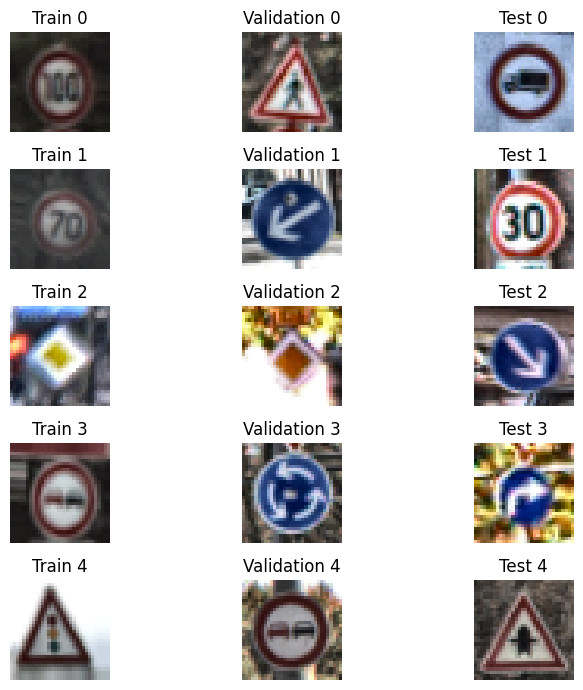

In [14]:
import matplotlib.pyplot as plt

def plot_data_samples(X_train, X_validation, X_test, num_samples=3):
    fig, ax = plt.subplots(num_samples, 3, figsize=(8, 7))
    for i in range(num_samples):
        ax[i, 0].imshow(X_train[i])
        ax[i, 0].set_title('Train '+str(i))
        ax[i, 1].imshow(X_validation[i])
        ax[i, 1].set_title('Validation '+str(i))
        ax[i, 2].imshow(X_test[i])
        ax[i, 2].set_title('Test '+str(i))
    for axes in ax.flatten():
        axes.axis('off')

    plt.tight_layout()
    plt.show()

plot_data_samples(X_train, X_validation, X_test, num_samples=5)


In [15]:
import os
from google.colab import drive
drive.mount('/content/drive')

DIR = '/content/drive/MyDrive/models'
if not os.path.exists(DIR) :
    os.makedirs(DIR)

Mounted at /content/drive


In [16]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

from tensorflow.keras.layers import Flatten

keep_prob = tf.placeholder(tf.float32) # for fully-connected layers
keep_prob_conv = tf.placeholder(tf.float32) # for convolutional layers
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))

class VGGnet :

    def __init__(self, n_out=43, mu=0, sigma=0.1, learning_rate=0.0007) :
        # Hyperparameters
        self.mu = mu
        self.sigma = sigma

        # Layer 1: Convolutional. Input = 32x32x3. Output = 32x32x32.
        self.conv1_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 3, 32), mean = self.mu, stddev = self.sigma))
        self.conv1_b = tf.Variable(tf.zeros(32))
        self.conv1   = tf.nn.conv2d(x, self.conv1_W, strides=[1, 1, 1, 1], padding='SAME') + self.conv1_b

        # ReLu Activation.
        self.conv1 = tf.nn.relu(self.conv1)

        # Layer 2: Convolutional. Input = 32x32x32. Output = 32x32x32.
        self.conv2_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 32, 32), mean = self.mu, stddev = self.sigma))
        self.conv2_b = tf.Variable(tf.zeros(32))
        self.conv2   = tf.nn.conv2d(self.conv1, self.conv2_W, strides=[1, 1, 1, 1], padding='SAME') + self.conv2_b
        # ReLu Activation.
        self.conv2 = tf.nn.relu(self.conv2)

        # Pooling. Input = 32x32x32. Output = 16x16x32.
        self.conv2 = tf.nn.max_pool(self.conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        self.conv2 = tf.nn.dropout(self.conv2, keep_prob_conv) # dropout

        # Layer 3: Convolutional. Input = 16x16x32. Output = 16x16x64.
        self.conv3_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 32, 64), mean = self.mu, stddev = self.sigma))
        self.conv3_b = tf.Variable(tf.zeros(64))
        self.conv3   = tf.nn.conv2d(self.conv2, self.conv3_W, strides=[1, 1, 1, 1], padding='SAME') + self.conv3_b

        # ReLu Activation.
        self.conv3 = tf.nn.relu(self.conv3)

        # Layer 4: Convolutional. Input = 16x16x32. Output = 16x16x64.
        self.conv4_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 64, 64), mean = self.mu, stddev = self.sigma))
        self.conv4_b = tf.Variable(tf.zeros(64))
        self.conv4   = tf.nn.conv2d(self.conv3, self.conv4_W, strides=[1, 1, 1, 1], padding='SAME') + self.conv4_b

        # ReLu Activation.
        self.conv4 = tf.nn.relu(self.conv4)

        # Pooling. Input = 16x16x64. Output = 8x8x64.
        self.conv4 = tf.nn.max_pool(self.conv4, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        self.conv4 = tf.nn.dropout(self.conv4, keep_prob_conv) # dropout

        # Layer 5: Convolutional. Input = 8x8x64. Output = 8x8x128.
        self.conv5_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 64, 128), mean = self.mu, stddev = self.sigma))
        self.conv5_b = tf.Variable(tf.zeros(128))
        self.conv5   = tf.nn.conv2d(self.conv4, self.conv5_W, strides=[1, 1, 1, 1], padding='SAME') + self.conv5_b

        # ReLu Activation.
        self.conv5 = tf.nn.relu(self.conv5)

        # Layer 6: Convolutional. Input = 8x8x128. Output = 8x8x128.
        self.conv6_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 128, 128), mean = self.mu, stddev = self.sigma))
        self.conv6_b = tf.Variable(tf.zeros(128))
        self.conv6   = tf.nn.conv2d(self.conv5, self.conv6_W, strides=[1, 1, 1, 1], padding='SAME') + self.conv6_b

        # ReLu Activation.
        self.conv6 = tf.nn.relu(self.conv6)

        # Pooling. Input = 8x8x128. Output = 4x4x128.
        self.conv6 = tf.nn.max_pool(self.conv6, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        self.conv6 = tf.nn.dropout(self.conv6, keep_prob_conv) # dropout

        # Flatten. Input = 4x4x128. Output = 2048.
        self.fc0   = Flatten()(self.conv6)

        # Layer 7: Fully Connected. Input = 2048. Output = 128.
        self.fc1_W = tf.Variable(tf.truncated_normal(shape=(2048, 128), mean = self.mu, stddev = self.sigma))
        self.fc1_b = tf.Variable(tf.zeros(128))
        self.fc1   = tf.matmul(self.fc0, self.fc1_W) + self.fc1_b

        # ReLu Activation.
        self.fc1    = tf.nn.relu(self.fc1)
        self.fc1    = tf.nn.dropout(self.fc1, keep_prob) # dropout

        # Layer 8: Fully Connected. Input = 128. Output = 128.
        self.fc2_W  = tf.Variable(tf.truncated_normal(shape=(128, 128), mean = self.mu, stddev = self.sigma))
        self.fc2_b  = tf.Variable(tf.zeros(128))
        self.fc2    = tf.matmul(self.fc1, self.fc2_W) + self.fc2_b

        # ReLu Activation.
        self.fc2    = tf.nn.relu(self.fc2)
        self.fc2    = tf.nn.dropout(self.fc2, keep_prob) # dropout

        # Layer 9: Fully Connected. Input = 128. Output = n_out.
        self.fc3_W  = tf.Variable(tf.truncated_normal(shape=(128, n_out), mean = self.mu, stddev = self.sigma))
        self.fc3_b  = tf.Variable(tf.zeros(n_out))
        self.logits = tf.matmul(self.fc2, self.fc3_W) + self.fc3_b

        # training operation
        self.one_hot_y = tf.one_hot(y, n_out)
        self.cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=self.one_hot_y,logits=self.logits)
        self.loss_operation = tf.reduce_mean(self.cross_entropy)
        self.optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
        self.training_operation = self.optimizer.minimize(self.loss_operation)

        # accuracy
        self.correct_prediction = tf.equal(tf.argmax(self.logits, 1), tf.argmax(self.one_hot_y, 1))
        self.accuracy_operation = tf.reduce_mean(tf.cast(self.correct_prediction, tf.float32))

        # save all variables
        self.saver = tf.train.Saver()

    def y_predict(self, X_data, BATCH_SIZE=64) :
        num_examples = len(X_data)
        y_pred = np.zeros(num_examples, dtype=np.int32)
        sess = tf.get_default_session()
        for offset in range(0, num_examples, BATCH_SIZE):
            batch_x = X_data[offset:offset+BATCH_SIZE]
            y_pred[offset:offset+BATCH_SIZE] = sess.run(tf.argmax(self.logits, 1),
                               feed_dict={x:batch_x, keep_prob:1, keep_prob_conv:1})
        return y_pred

    def evaluate(self, X_data, y_data, BATCH_SIZE=64):
        num_examples = len(X_data)
        total_accuracy = 0
        sess = tf.get_default_session()
        for offset in range(0, num_examples, BATCH_SIZE):
            batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
            accuracy = sess.run(self.accuracy_operation,
                                feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0, keep_prob_conv: 1.0 })
            total_accuracy += (accuracy * len(batch_x))
        return total_accuracy / num_examples


Instructions for updating:
non-resource variables are not supported in the long term


In [17]:
from sklearn.utils import shuffle

# Reduce the number of training examples
num_training_examples = 60000

# Shuffle and select a subset of training data
X_train_subset, y_train_subset = shuffle(X_train[:num_training_examples], y_train[:num_training_examples])

EPOCHS = 13
BATCH_SIZE = 64
model_1 = VGGnet(n_out=n_classes)
model_name = "model_1"

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(y_train_subset)  # Use the size of the subset
    print("Training...")

    for i in range(EPOCHS):
        X_train_subset, y_train_subset = shuffle(X_train_subset, y_train_subset)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_subset[offset:end], y_train_subset[offset:end]
            try:
                sess.run(model_1.training_operation,
                        feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5, keep_prob_conv: 0.7})
            except Exception as e:
                print("Error during training:", e)

        validation_accuracy = model_1.evaluate(X_validation, y_validation)
        print("EPOCH {} : Validation Accuracy = {:.3f}".format(i+1, validation_accuracy))

    model_1.saver.save(sess, os.path.join(DIR, model_name))
    print("Model saved")


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



Training...
EPOCH 1 : Validation Accuracy = 0.226
EPOCH 2 : Validation Accuracy = 0.411
EPOCH 3 : Validation Accuracy = 0.742
EPOCH 4 : Validation Accuracy = 0.840
EPOCH 5 : Validation Accuracy = 0.909
EPOCH 6 : Validation Accuracy = 0.935
EPOCH 7 : Validation Accuracy = 0.962
EPOCH 8 : Validation Accuracy = 0.984
EPOCH 9 : Validation Accuracy = 0.979
EPOCH 10 : Validation Accuracy = 0.987
EPOCH 11 : Validation Accuracy = 0.988
EPOCH 12 : Validation Accuracy = 0.991
EPOCH 13 : Validation Accuracy = 0.986
Model saved


In [18]:
from sklearn.metrics import precision_score, recall_score, f1_score
with tf.Session() as sess:
    model_1.saver.restore(sess, os.path.join(DIR, "model_1"))
    #test_accuracy = model_1.evaluate(X_test, y_test)
    y_pred = model_1.y_predict(X_test)
    test_accuracy = sum(y_test == y_pred)/len(y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))
    # Assuming y_test and y_pred are available

    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print("Precision: {:.3f}".format(precision))
    print("Recall: {:.3f}".format(recall))
    print("F1 Score: {:.3f}".format(f1))





Test Accuracy = 0.963
Precision: 0.966
Recall: 0.963
F1 Score: 0.964


In [19]:
import numpy as np
from sklearn.metrics import precision_recall_curve, auc, average_precision_score



# Compute precision-recall curve and area under the curve (AUC) for each class
precision = dict()
recall = dict()
average_precision = dict()
num_classes = len(np.unique(y_test))

for i in range(num_classes):  # Assuming num_classes is defined
    precision[i], recall[i], _ = precision_recall_curve(y_test == i, y_pred == i)
    average_precision[i] = average_precision_score(y_test == i, y_pred == i)

# Compute mAP (mean Average Precision)
mAP = np.mean(list(average_precision.values()))
print("mAP:", mAP)

# print(precision)
# print(recall)

mAP: 0.9135813812342045


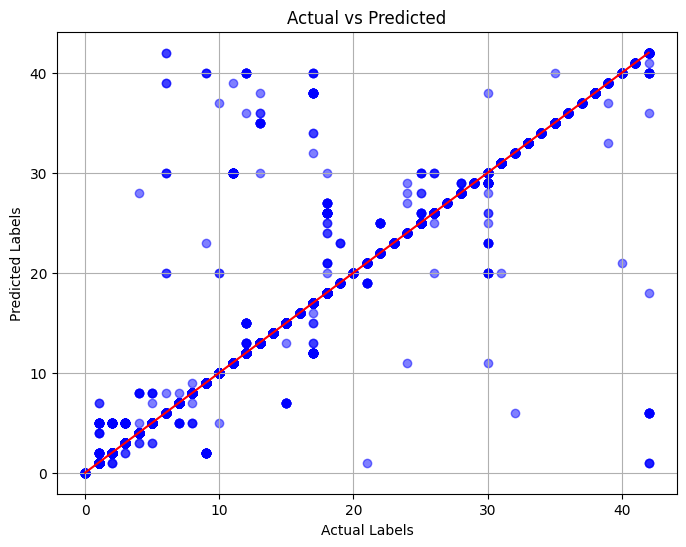

In [20]:
import matplotlib.pyplot as plt

# Plotting the actual labels against the predicted labels
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # Diagonal line indicating perfect predictions
plt.title('Actual vs Predicted')
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.grid(True)
plt.show()


In [21]:
import pandas as pd
import requests

# URL of the CSV file
url = "https://github.com/thibo73800/capsnet-traffic-sign-classifier/raw/master/signnames.csv"

# Download the file
response = requests.get(url)

# Check if download was successful
if response.status_code == 200:
    # Save the content to a local file
    with open("signnames.csv", "wb") as sign_names_file:
        sign_names_file.write(response.content)
else:
    print("Failed to download the file")

# Read the CSV file using pandas
sign_names = pd.read_csv("signnames.csv")
# Display the first 10 rows
print(sign_names.head(42))


    ClassId                                      SignName
0         0                          Speed limit (20km/h)
1         1                          Speed limit (30km/h)
2         2                          Speed limit (50km/h)
3         3                          Speed limit (60km/h)
4         4                          Speed limit (70km/h)
5         5                          Speed limit (80km/h)
6         6                   End of speed limit (80km/h)
7         7                         Speed limit (100km/h)
8         8                         Speed limit (120km/h)
9         9                                    No passing
10       10  No passing for vehicles over 3.5 metric tons
11       11         Right-of-way at the next intersection
12       12                                 Priority road
13       13                                         Yield
14       14                                          Stop
15       15                                   No vehicles
16       16   

Choose upload option:
1. Upload a single image
2. Upload multiple images
Enter your choice (1/2): 2


Saving 30.png to 30 (1).png
Saving 30_2.png to 30_2 (1).png
Saving 60 to 60 (1)


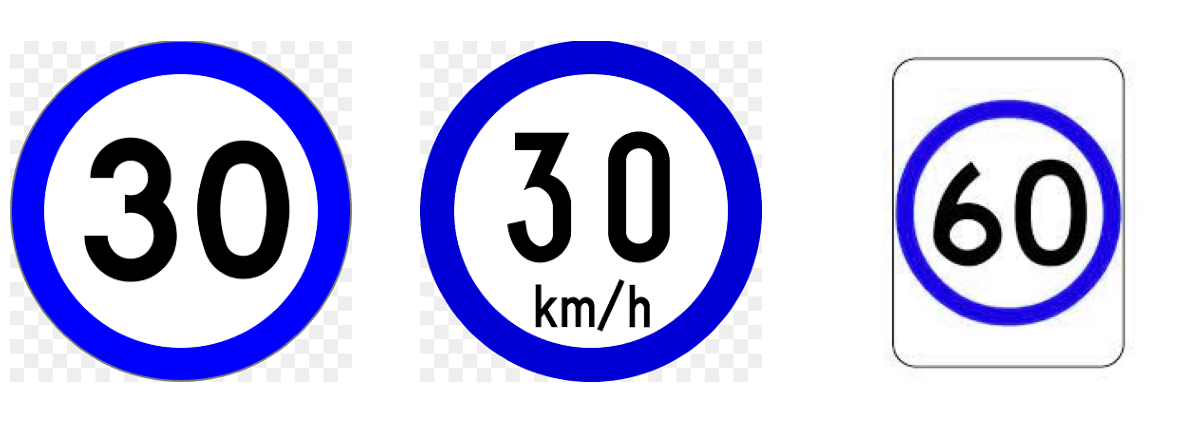

Prediction: 


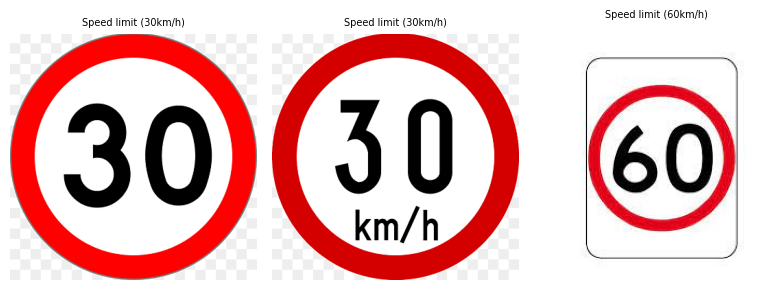

In [ ]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from google.colab import files

def upload_images():
    print("Choose upload option:")
    print("1. Upload a single image")
    print("2. Upload multiple images")
    # print("3. Upload images from a folder")
    choice = input("Enter your choice (1/2): ")

    if choice == '1':
        uploaded = files.upload()
    elif choice == '2':
        uploaded = files.upload()
    else:
        print("Invalid choice.")
        return None

    return uploaded

def y_predict_model(X_data, top_k=1):
    num_examples = len(X_data)
    y_pred = np.zeros((num_examples, top_k), dtype=np.int32)
    y_prob = np.zeros((num_examples, top_k))
    with tf.Session() as sess:
        model_1.saver.restore(sess, os.path.join(DIR, "model_1"))
        y_prob, y_pred = sess.run(tf.nn.top_k(tf.nn.softmax(model_1.logits), k=top_k),
                             feed_dict={x:X_data, keep_prob:1, keep_prob_conv:1})
    return y_prob,y_pred

def preprocessing_function(img):
    img_resized = cv2.resize(img, (32, 32))
    img_normalized = img_resized / 255.0
    return img_normalized

def visualize_predictions(uploaded_files, y_pred):
    fig, ax = plt.subplots(1, len(uploaded_files), figsize=(8, 3))  # Adjusted figure size
    if len(uploaded_files) == 1:
        ax = [ax]  # Ensure ax is a list even if only one image is uploaded
    print('Prediction: ')
    for i in range(len(uploaded_files)):
        img = plt.imread(uploaded_files[i])
        ax[i].imshow(img)
        ax[i].axis('off')
        ax[i].set_title('' + sign_names.iloc[y_pred[i][0]]['SignName'], fontsize=7)

    plt.tight_layout()  # Ensures tight layout
    plt.show()


# Upload images
uploaded = upload_images()

if uploaded:
    # Get list of uploaded image file names
    uploaded_files = list(uploaded.keys())
    n_new = len(uploaded_files)

    # Plot the uploaded images
    fig, ax = plt.subplots(1, n_new, figsize=(15, 15))

    if n_new == 1:
        ax = [ax]  # Ensure ax is a list even if only one image is uploaded

    new_data = []

    for i, file_name in enumerate(uploaded_files):
        img = cv2.imdecode(np.frombuffer(uploaded[file_name], np.uint8), -1)
        ax[i].imshow(img)
        ax[i].axis('off')
        img = cv2.resize(img, (32, 32), interpolation=cv2.INTER_AREA)  # resize to 32x32
        new_data.append(img)

    plt.show()

    # Preprocess data
    new_data_proc = np.zeros((len(new_data), 32, 32, 3))
    for i in range(n_new):
        new_data_proc[i] = preprocessing_function(new_data[i])

    # Make predictions
    _, y_pred = y_predict_model(new_data_proc)

    # Show the prediction results
    visualize_predictions(uploaded_files, y_pred)


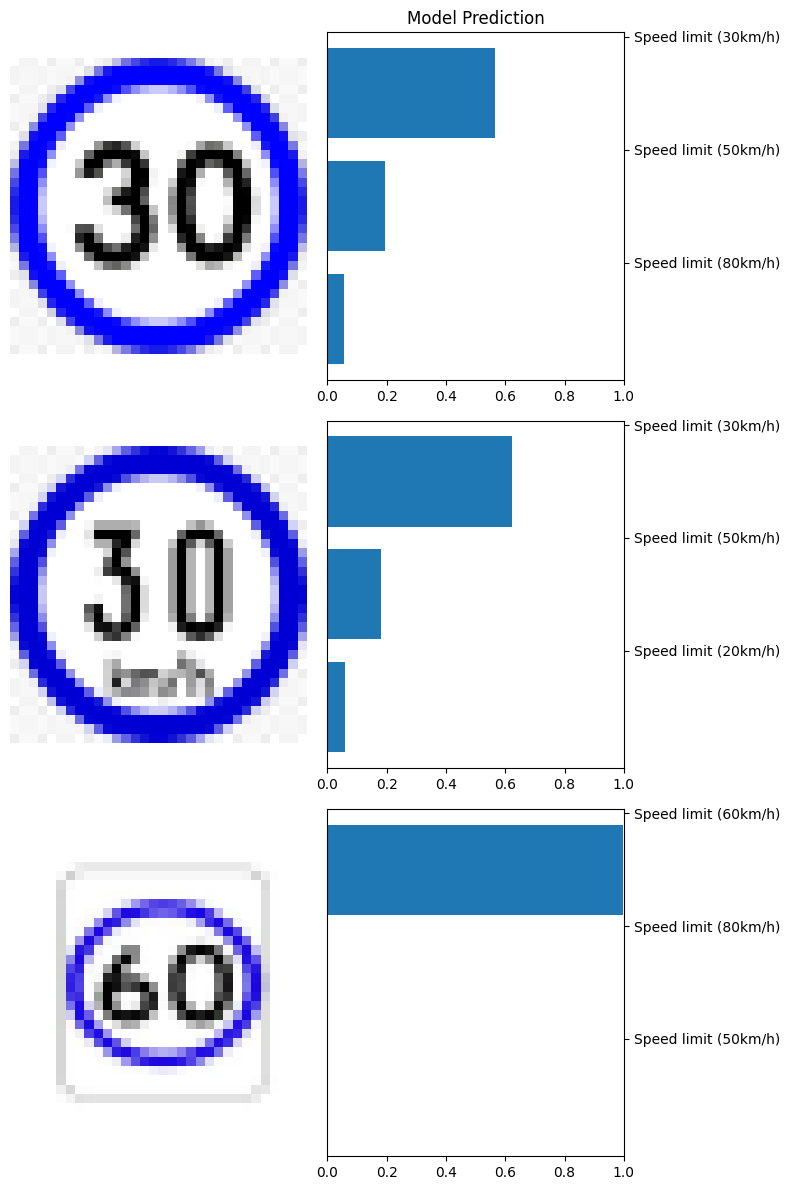

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_models(X_data):
    n_examples = len(X_data)
    n_rows = n_examples if n_examples > 1 else 1  # Number of rows for subplots
    fig, ax = plt.subplots(n_rows, 2, figsize=(8, 4 * n_rows))  # Dynamic creation of subplots

    # Ensure ax is a list even if only one image is uploaded
    if n_rows == 1:
        ax = [ax]

    for i, image in enumerate(X_data):
        X_data_proc = contrast_norm(image)
        prob, pred = y_predict_model(np.array([X_data_proc]), top_k=3)  # Assuming y_predict_model takes a batch of images

        labels = pred[0]
        names = [sign_names.iloc[l]['SignName'] for l in labels]
        bar_locations = np.arange(3)[::-1]

        ax[i][0].imshow(image)
        ax[i][0].axis('off')
        ax[i][1].barh(bar_locations, prob[0])
        ax[i][1].set_yticks(0.5 + bar_locations)
        ax[i][1].set_yticklabels(names)
        ax[i][1].yaxis.tick_right()
        ax[i][1].set_xlim([0, 1])

    ax[0][1].set_title('Model Prediction')
    fig.tight_layout()

# Call visualize_models with new_data
visualize_models(new_data)


Choose upload option:
1. Upload a single image
2. Upload multiple images
3. Capture image via camera
Enter your choice (1/2/3): 3


<IPython.core.display.Javascript object>

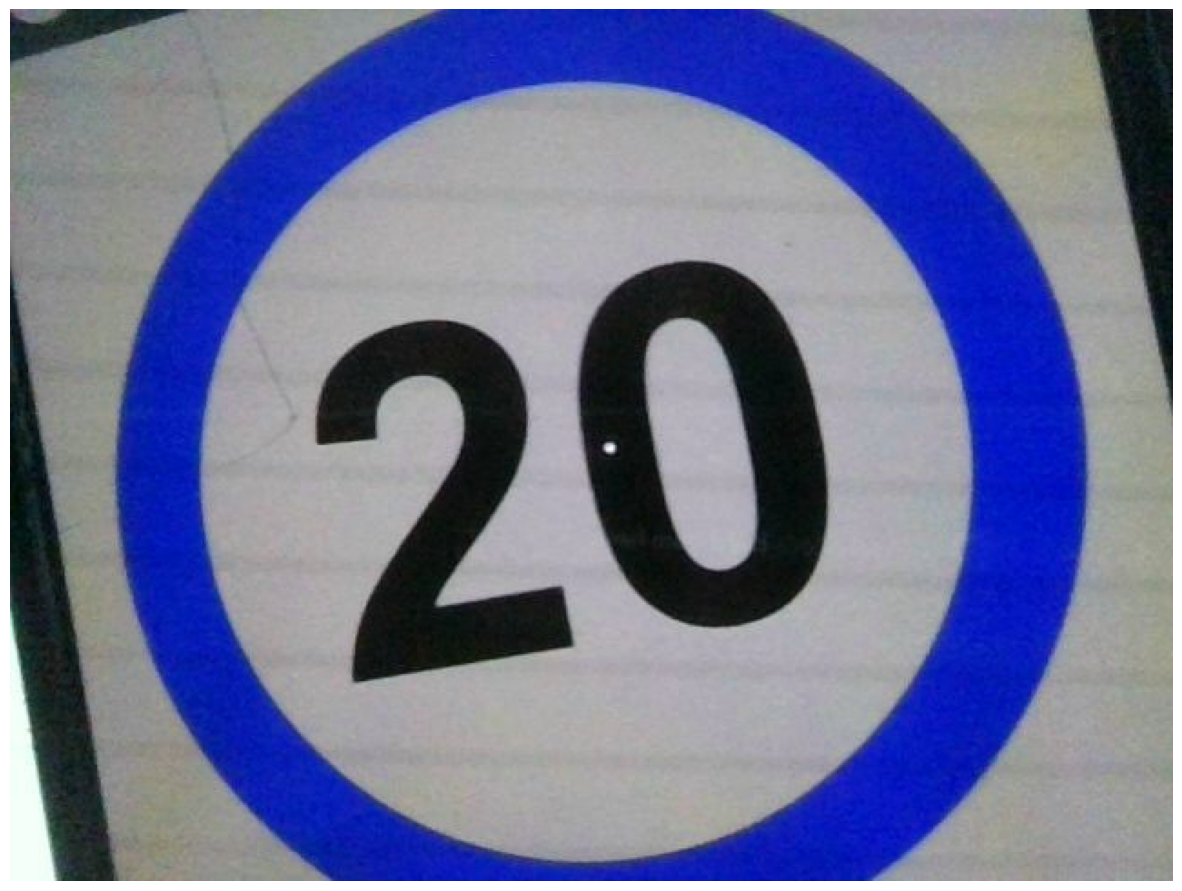

Prediction: 


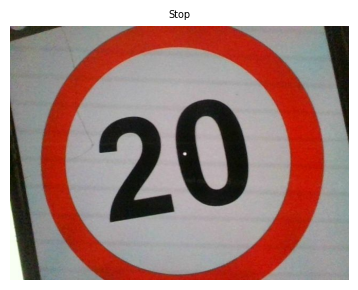

In [40]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from google.colab import files
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
def upload_images():
    print("Choose upload option:")
    print("1. Upload a single image")
    print("2. Upload multiple images")
    print("3. Capture image via camera")
    choice = input("Enter your choice (1/2/3): ")

    if choice == '1':
        uploaded = files.upload()
    elif choice == '2':
        uploaded = files.upload()
    elif choice == '3':
        uploaded = take_photo()
        if uploaded:
            return {'camera_image.jpg': open(uploaded, 'rb').read()}
        else:
            return None
    else:
        print("Invalid choice.")
        return None

    return uploaded

def take_photo(filename='camera_image.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');

      capture.textContent = 'Capture';
      capture.style.float = 'center';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      video.style.width = '40%';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

def y_predict_model(X_data, top_k=1):
    num_examples = len(X_data)
    y_pred = np.zeros((num_examples, top_k), dtype=np.int32)
    y_prob = np.zeros((num_examples, top_k))
    with tf.Session() as sess:
        model_1.saver.restore(sess, os.path.join(DIR, "model_1"))
        y_prob, y_pred = sess.run(tf.nn.top_k(tf.nn.softmax(model_1.logits), k=top_k),
                             feed_dict={x:X_data, keep_prob:1, keep_prob_conv:1})
    return y_prob,y_pred

def preprocessing_function(img):
    img_resized = cv2.resize(img, (32, 32))
    img_normalized = img_resized / 255.0
    return img_normalized

def visualize_predictions(uploaded_files, y_pred):
    fig, ax = plt.subplots(1, len(uploaded_files), figsize=(8, 3))  # Adjusted figure size
    if len(uploaded_files) == 1:
        ax = [ax]  # Ensure ax is a list even if only one image is uploaded
    print('Prediction: ')
    for i in range(len(uploaded_files)):
        img = plt.imread(uploaded_files[i])
        ax[i].imshow(img)
        ax[i].axis('off')
        ax[i].set_title('' + sign_names.iloc[y_pred[i][0]]['SignName'], fontsize=7)

    plt.tight_layout()  # Ensures tight layout
    plt.show()

# Upload images
uploaded = upload_images()

if uploaded:
    # Get list of uploaded image file names
    uploaded_files = list(uploaded.keys())
    n_new = len(uploaded_files)

    # Plot the uploaded images
    fig, ax = plt.subplots(1, n_new, figsize=(15, 15))

    if n_new == 1:
        ax = [ax]  # Ensure ax is a list even if only one image is uploaded

    new_data = []

    for i, file_name in enumerate(uploaded_files):
        img = cv2.imdecode(np.frombuffer(uploaded[file_name], np.uint8), -1)
        ax[i].imshow(img)
        ax[i].axis('off')
        img = cv2.resize(img, (32, 32), interpolation=cv2.INTER_AREA)  # resize to 32x32
        new_data.append(img)

    plt.show()

    # Preprocess data
    new_data_proc = np.zeros((len(new_data), 32, 32, 3))
    for i in range(n_new):
        new_data_proc[i] = preprocessing_function(new_data[i])

    # Make predictions
    _, y_pred = y_predict_model(new_data_proc)

    # Show the prediction results
    visualize_predictions(uploaded_files, y_pred)


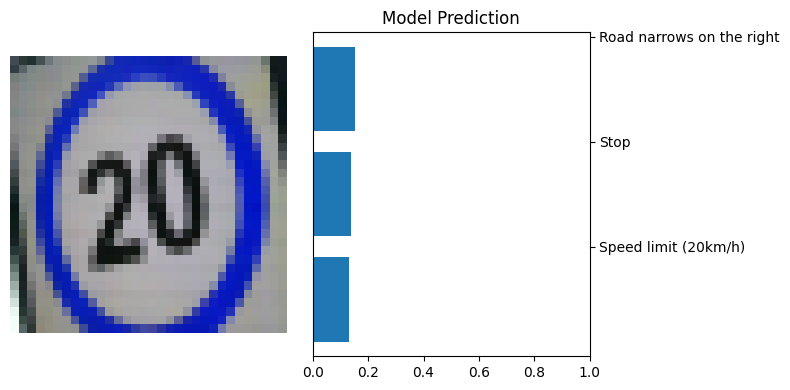

In [41]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_models(X_data):
    n_examples = len(X_data)
    n_rows = n_examples if n_examples > 1 else 1  # Number of rows for subplots
    fig, ax = plt.subplots(n_rows, 2, figsize=(8, 4 * n_rows))  # Dynamic creation of subplots

    # Ensure ax is a list even if only one image is uploaded
    if n_rows == 1:
        ax = [ax]

    for i, image in enumerate(X_data):
        X_data_proc = contrast_norm(image)
        prob, pred = y_predict_model(np.array([X_data_proc]), top_k=3)  # Assuming y_predict_model takes a batch of images

        labels = pred[0]
        names = [sign_names.iloc[l]['SignName'] for l in labels]
        bar_locations = np.arange(3)[::-1]

        ax[i][0].imshow(image)
        ax[i][0].axis('off')
        ax[i][1].barh(bar_locations, prob[0])
        ax[i][1].set_yticks(0.5 + bar_locations)
        ax[i][1].set_yticklabels(names)
        ax[i][1].yaxis.tick_right()
        ax[i][1].set_xlim([0, 1])

    ax[0][1].set_title('Model Prediction')
    fig.tight_layout()

# Call visualize_models with new_data
visualize_models(new_data)
